In [3]:
import numpy as np
import pandas as pd
import scipy as sp

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from collections import Counter
import preproc

In [4]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
stops_tidy = pd.read_csv('../data/corpus.csv',index_col=0)
stops_tidy

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...,0.0,0.097100,0.534050,0.0,0.0,0.0,0.145650,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...,0.0,0.200297,0.578636,0.0,0.0,0.0,0.155787,...,0.000000,0.000000,0.022255,0.0,0.222552,0.311573,0.022255,0.0,0.066766,0.0
2,Bur,Com,horis anni invenire quartam coniugationem comp...,0.0,0.230022,0.575055,0.0,0.0,0.0,0.000000,...,0.046004,0.000000,0.000000,0.0,0.253024,0.138013,0.046004,0.0,0.230022,0.0
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...,0.0,0.243044,0.710436,0.0,0.0,0.0,0.037391,...,0.000000,0.000000,0.000000,0.0,0.280435,0.168261,0.000000,0.0,0.037391,0.0
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...,0.0,0.649435,0.409426,0.0,0.0,0.0,0.070591,...,0.000000,0.000000,0.000000,0.0,0.395308,0.211772,0.000000,0.0,0.070591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,Bur,Fid,ostendat quod secundum veritatem est homo cum ...,0.0,0.024500,0.538996,0.0,0.0,0.0,0.171499,...,0.000000,0.000000,0.000000,0.0,0.587995,0.024500,0.000000,0.0,0.024500,0.0
1181,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...,0.0,0.000000,0.421459,0.0,0.0,0.0,0.049583,...,0.000000,0.000000,0.000000,0.0,0.223125,0.049583,0.024792,0.0,0.074375,0.0
1182,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...,0.0,0.000000,0.738485,0.0,0.0,0.0,0.096324,...,0.000000,0.032108,0.000000,0.0,0.481621,0.064216,0.032108,0.0,0.032108,0.0
1183,Bur,Fid,uxorem suam et concepit et genuit quare propte...,0.0,0.000000,0.666795,0.0,0.0,0.0,0.156893,...,0.000000,0.078446,0.000000,0.0,0.274563,0.039223,0.000000,0.0,0.039223,0.0


In [6]:
testing_df = stops_tidy[(stops_tidy.Translator != 'Myst') & (stops_tidy.Work != 'Hom')]
samp_ctr = Counter(testing_df.Translator)
# each time, get a balanced sample, sized at half the minimum class count
# which, for now, is 17 (Arist has 35 samples)
SAMPLE_SIZE = min(samp_ctr.values()) // 2


In [7]:
global_scores = []
rng = np.random.RandomState(42)

# SLOW. It's faster with n_jobs=-1, but then it's not reproduceable 
# because threading makes it non-deterministic.
rf = RandomForestClassifier(
    n_estimators=500, max_features=3, n_jobs=1, random_state=rng
)

# 100 5-fold CV runs, take average of averages, simple accuracy
for _ in range(100):
    samp = (
        testing_df.groupby("Translator")
        .apply(lambda x: x.sample(SAMPLE_SIZE, random_state=rng))
        .reset_index(drop=True)
    )
    X = samp.drop(["Translator", "Work", "Chunk"], axis=1)
    y = samp.Translator
    scores = cross_val_score(rf, X, y, cv=5)
    global_scores.append(scores.mean())


a = np.array(global_scores)
f"{a.mean():.4%} ± {a.std() * 2:.2%}"

'96.0014% ± 3.70%'

In [8]:
stops = []

with open("../data/functionwords.txt", "r") as file:
    for line in file:
        words = [x for x in line.lower().split() if x != "/"]
        stops.append(list(set(words)))

flat_stops = [item for sublist in stops for item in sublist]

In [9]:
def sample(
    ww: list, sz: int = 1000, rng: np.random.RandomState = np.random.RandomState()
) -> str:
    start = rng.randint(len(ww)) - sz
    return " ".join(ww[start : start + sz])

In [10]:
v = TfidfVectorizer(use_idf=False, analyzer="word", decode_error="replace")
# only count our stopwords
v.fit(flat_stops)

def vectorize(s: str) -> pd.DataFrame:
    # make a df with all function words
    X = v.transform([s])
    df = pd.DataFrame(X.toarray())
    df.columns = v.get_feature_names_out()

    # make a blank df
    stops_df_combined = pd.DataFrame()
    for ary in stops:
        ary = sorted(list(set(ary)))
        # each array is a list of spelling variants. sum the counts for all the
        # variants of this stopword that appear in the df, using the first array
        # entry as the label
        stops_df_combined[ary[0]] = df[df.columns.intersection(ary)].sum(axis=1)
    return stops_df_combined

In [11]:
# We need to manually read the whole file, because we take 1000 word subsamples
# from any starting point.

fn = '../data/txt/Myst3.txt'
with open(fn, 'r') as fh:
    raw = fh.read()
clean = preproc._preprocess_text(raw)
myst3 = clean.split()

In [12]:
myst3_count = Counter()
rng = np.random.RandomState(42)
rf = RandomForestClassifier(
    n_estimators=500, max_features=3, n_jobs=1, random_state=rng
)

for _ in range(20):
    # refit the classifier on a new random sample
    samp = (
        testing_df.groupby("Translator")
        .apply(lambda x: x.sample(SAMPLE_SIZE, random_state=rng))
        .reset_index(drop=True)
    )
    X = samp.drop(["Translator", "Work", "Chunk"], axis=1)
    y = samp.Translator
    rf.fit(X, y)
    for _ in range(50):
        # predict for 50 samples with this classifier
        myst3_count.update(rf.predict(vectorize(sample(myst3, rng=rng))))

In [13]:
fn = '../data/txt/Myst6.txt'
with open(fn, 'r') as fh:
    raw = fh.read()
clean = preproc._preprocess_text(raw)
myst6 = clean.split()

In [14]:
myst6_count = Counter()
rng = np.random.RandomState(42)
rf = RandomForestClassifier(
    n_estimators=500, max_features=3, n_jobs=1, random_state=rng
)

for _ in range(20):
    # refit the classifier on a new random sample
    samp = (
        testing_df.groupby("Translator")
        .apply(lambda x: x.sample(SAMPLE_SIZE, random_state=rng))
        .reset_index(drop=True)
    )
    X = samp.drop(["Translator", "Work", "Chunk"], axis=1)
    y = samp.Translator
    rf.fit(X, y)
    for _ in range(50):
        # predict for 50 samples with this classifier
        myst6_count.update(rf.predict(vectorize(sample(myst6, rng=rng))))

In [15]:
myst6_df = pd.DataFrame([myst6_count]).T.reset_index()
myst6_df.columns = ['translator','n']
myst6_df

,translator,n
0,Bur,139
1,Wil,183
2,Bar,259
3,Anon,262
4,Jam,90
5,Arist,67


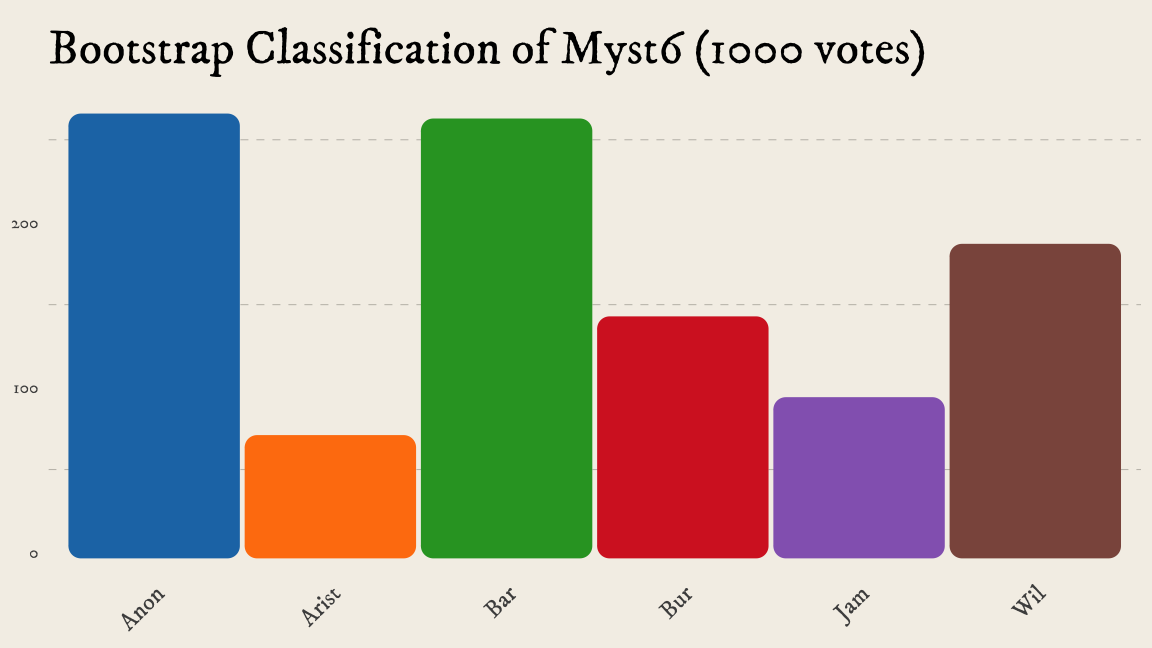

In [23]:
%%R -i myst6_df -h 4.5 -w 8 -u in -r 144

library(ggplot2)
library(paletteer)
library(showtext)
library(ggchicklet)
font_add_google("IM Fell DW Pica", "fnt")
showtext_auto()

bgcol = '#f4f0e8'
fgcol = 'black'

ggplot(data=myst6_df, aes(x=as.factor(translator),y=n)) +
geom_chicklet(size=3, aes(color=translator,fill=translator)) +
theme_minimal() +
scale_colour_paletteer_d("ggsci::category20_d3") +
scale_fill_paletteer_d("ggsci::category20_d3") +

ggtitle("Bootstrap Classification of Myst6 (1000 votes)") +
guides(color = guide_legend(ncol=1,override.aes =list(size=7, alpha=1))) +
    theme(
        panel.border = element_blank(),
        panel.background = element_rect(fill = bgcol,color=bgcol),
        plot.background = element_rect(fill = bgcol,color=bgcol),
        plot.title=element_text(margin=margin(10,0,10,0),size=24),
        legend.title=element_blank(),
        legend.position='none',
        legend.text=element_text(size=14),
        legend.key.size = unit(0, 'lines'),
        axis.title.x=element_blank(),
        axis.text.x=element_text(angle=45,size=12,hjust=1),
        # axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        # axis.text.y=element_blank(),
        # axis.ticks.y=element_blank(),
        text=element_text(family="fnt",color=fgcol),
        panel.grid.minor=element_line(color='#c4c0b8',linetype='dashed'),
        panel.grid.major=element_blank()
    )

# fn <- "../figures/bsrf_myst6.png"
# ggsave(fn, dpi=300, width=8, height=4.5)

In [17]:
myst3_df = pd.DataFrame([myst3_count]).T.reset_index()
myst3_df.columns = ['translator','n']

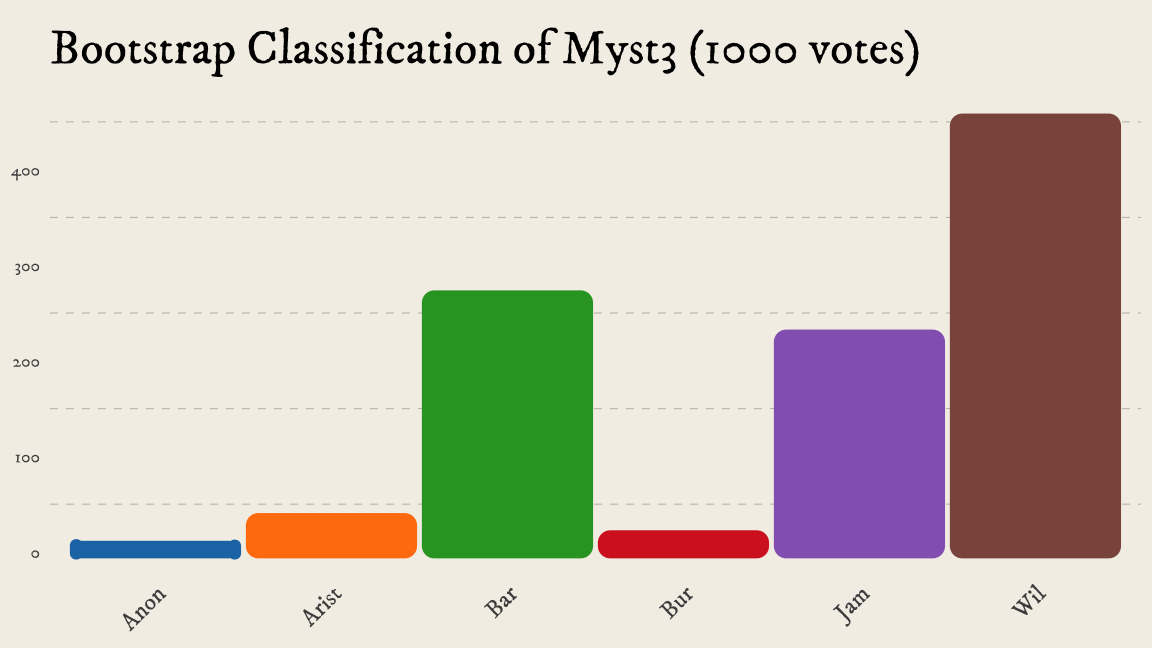

In [21]:
%%R -i myst3_df -h 4.5 -w 8 -u in -r 144

library(ggplot2)
library(paletteer)
library(showtext)
library(ggchicklet)
font_add_google("IM Fell DW Pica", "fnt")
showtext_auto()

bgcol = '#f4f0e8'
fgcol = 'black'

ggplot(data=myst3_df, aes(x=as.factor(translator),y=n)) +
geom_chicklet(size=3, aes(color=translator,fill=translator)) +
theme_minimal() +
scale_colour_paletteer_d("ggsci::category20_d3") +
scale_fill_paletteer_d("ggsci::category20_d3") +

ggtitle("Bootstrap Classification of Myst3 (1000 votes)") +
guides(color = guide_legend(ncol=1,override.aes =list(size=7, alpha=1))) +
    theme(
        panel.border = element_blank(),
        panel.background = element_rect(fill = bgcol,color=bgcol),
        plot.background = element_rect(fill = bgcol,color=bgcol),
        plot.title=element_text(margin=margin(10,0,10,0),size=24),
        legend.title=element_blank(),
        legend.position='none',
        legend.text=element_text(size=14),
        legend.key.size = unit(0, 'lines'),
        axis.title.x=element_blank(),
        axis.text.x=element_text(angle=45,size=12,hjust=1),
        # axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        # axis.text.y=element_blank(),
        # axis.ticks.y=element_blank(),
        text=element_text(family="fnt",color=fgcol),
        panel.grid.minor=element_line(color='#c4c0b8',linetype='dashed'),
        panel.grid.major=element_blank()
    )

# fn <- "../figures/bsrf_myst3.png"
# ggsave(fn, dpi=300, width=8, height=4.5)